# Spatiotemporal Rainfall Model Example

This workbook provides an example of how to set up and run a spatiotemporal rainfall model. It assumes that you have read the rainfall model overview in the documentation and tried the single site model workbook. The example demonstrates how to:
 - Change the probability distribution used for sampling raincell intensity
 - Use multiple gauge time series to set up a rainfall model
 - Make changes to the fitting procedure (adjusted parameter bounds and "fixed" parameters)
 - Get catchment-average time series outputs, as well as simulated series for gauge locations

The example is for a 2800 km$^{\mathrm{2}}$ catchment in the (eastern) Rhine basin (close to the border between Germany and the Czech Republic). Three sub-catchments are considered (shown in red in the map below). The model is set up using hourly gauge data from the Deutsche Wetterdienst.

<div>
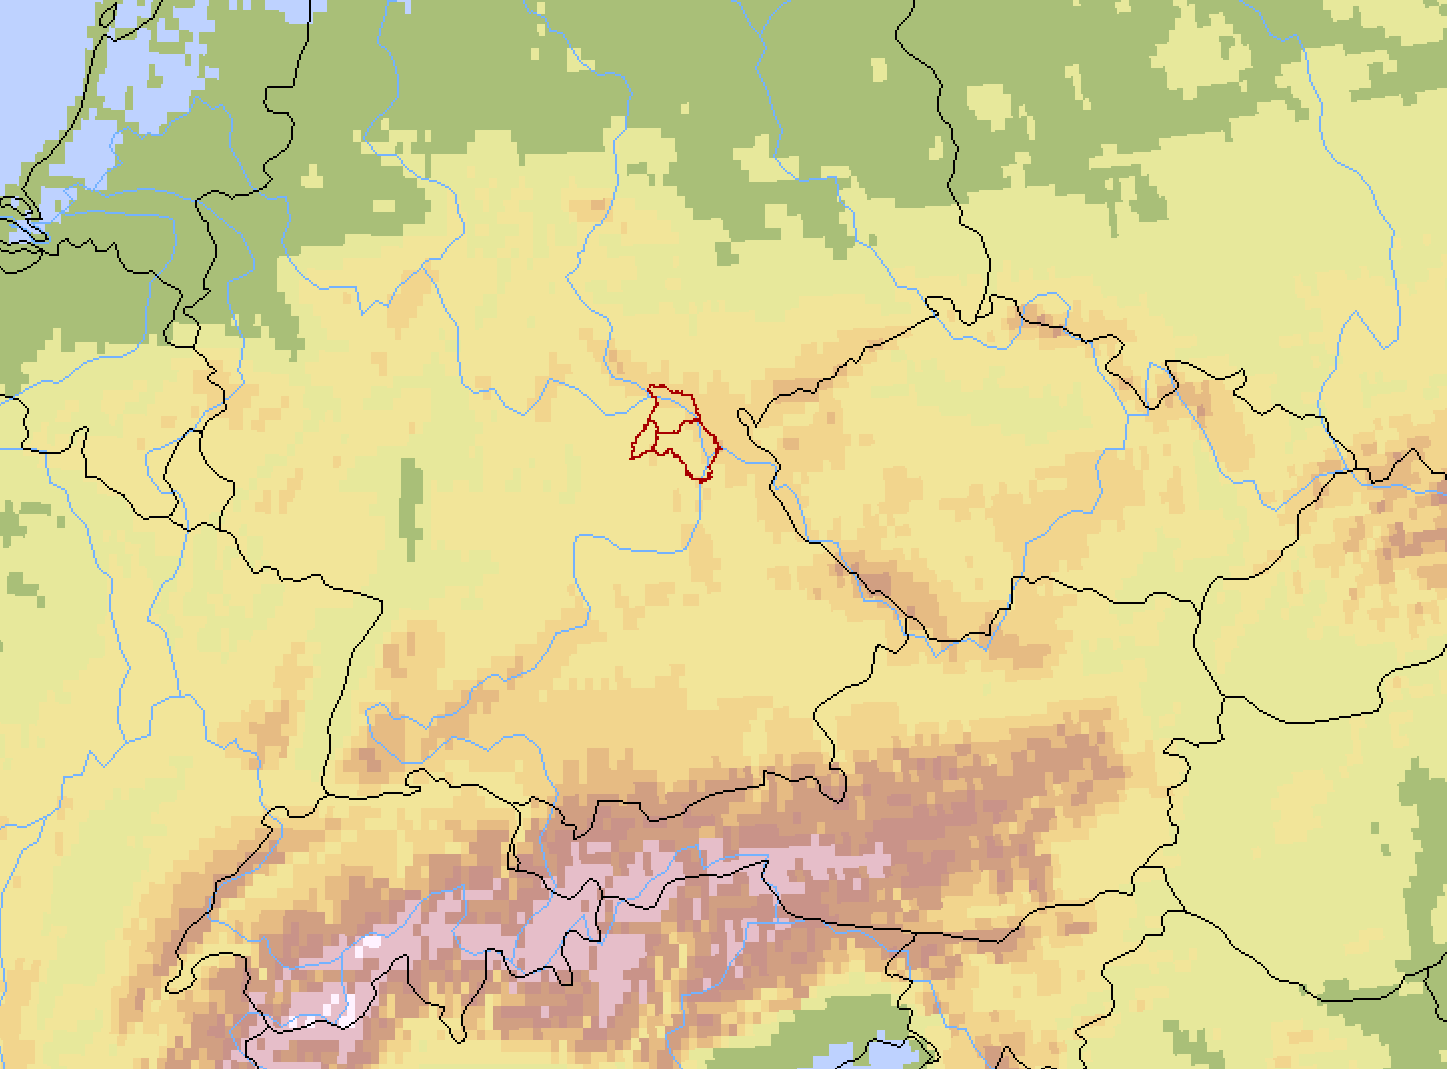
</div>

## Data Requirements

The minimal data requirements for a spatiotemporal model based on gauge data are:
 - A `.csv` file containing basic gauge metadata (location, name, ID, elevation) - see below
 - Files containing gauge time series (one file per gauge currently - same format as single site example)

Optional data files are:
 - A DEM - good if available.
 - A polygon shapefile containing catchment/sub-catchment boundaries if catchment-average outputs are requested.

These data files need to be prepared before setting up the rainfall model. See the documentation for a more complete description of these files.

## Preparation

Again we will start by running the cell below to enable plots to be displayed in the notebook.

In [ ]:
from bokeh.io import output_notebook
output_notebook()

## Initialisation

For this example we will accept the default definitions of statistics and weights to be used in model fitting. We do want to change the probability distribution used for raincell intensity, which means we can initialise the model as follows:

In [ ]:
import rwgen

rainfall_model = rwgen.RainfallModel(
    spatial_model=True,
    project_name='upper_rhine',
    input_timeseries='./input/gauge_data',
    intensity_distribution='weibull',
    point_metadata='./input/gauge_metadata.csv',
)

In the spatial model case, the `input_timeseries` argument is a path to the folder containing the time series data files. This is different to the single site example, where we just provided a path to a single file.

Note also that we have to specify `point_metadata` when initialising a spatial model. This file can be prepared in Excel and looks something like:

<div>
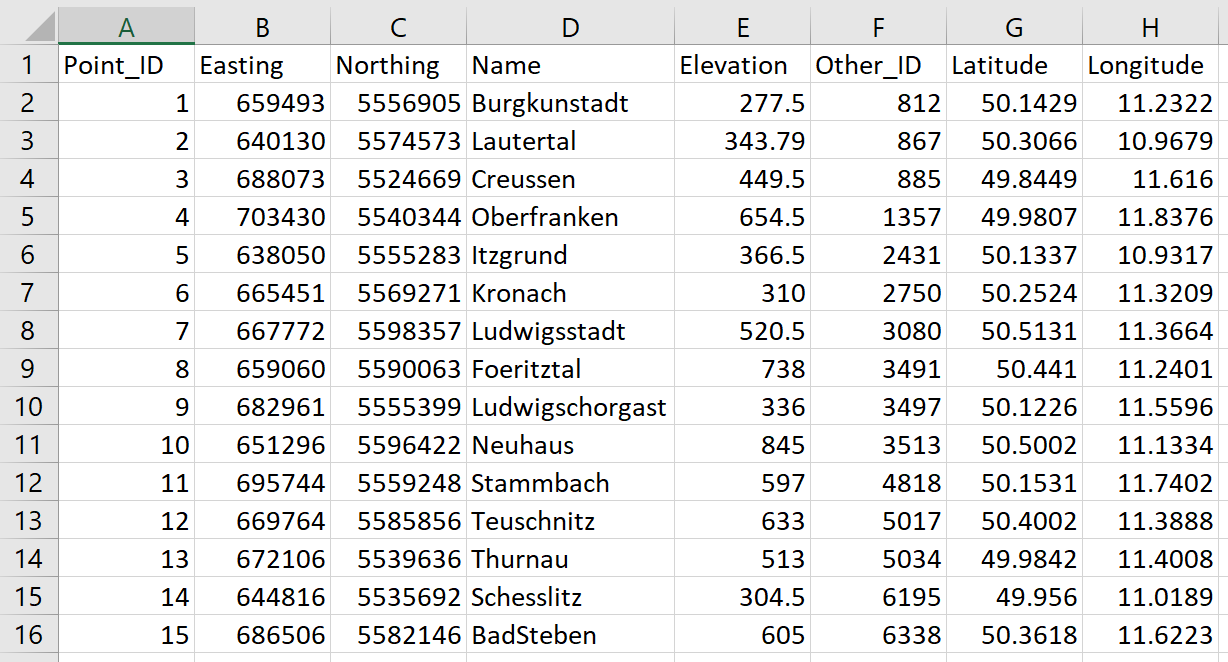
</div>

The `Other_ID`, `Latitude` and `Longitude` fields are ignored by the model.

## Preprocessing

Preprocessing can be done to calculate reference statistics from the gauge data in the same way as the single site example. This call will also calculate spatial cross-correlations if they are included in the `statistic_definitions` (which they are by default for a spatial model).

In [ ]:
rainfall_model.preprocess(dayfirst=True)  # i.e. dd/mm/yyyy hh:mm date format

We can also make a basic plot of the statistics by point/gauge location - for example:

In [ ]:
rainfall_model.plot(point_id=2)

This plot suggests that one or two "outliers" might be having a large influence on the skewness in April at this gauge. One way we can adjust this is to "trim" the data. By default this will look at the largest value in each month/season at each gauge and remove it if it is over two times the size of the next largest value (removing up to five values). These details can be adjusted using arguments to the preprocess method, but if we accept the defaults we can run the following (which will overwrite the `reference_statistics.csv` file unless we give it another name using the `output_filenames` argument - commented out example shown below)

In [ ]:
rainfall_model.preprocess(
    outlier_method='trim',
    # output_filenames={'statistics': 'reference_statistics2.csv'},
)

In [ ]:
rainfall_model.plot(point_id=2)

Using "trimming" brings the large 1-hour skewness value in April down from ~63 to ~17.

We can also plot up spatial cross-correlations to examine how the correlation between pairs of gauges changes with separation distance. This is useful to include when fitting the spatial model.

In [ ]:
rainfall_model.plot(plot_type='cross-correlation')

## Fitting

With no prior knowledge of suitable parameter values, we could do fitting in the default way (as per the single site example). This would take the form of:

```python
rainfall_model.fit(
    n_workers=4,  # for e.g. a 4-core computer
)
```

To speed things up for this example and to demonstrate additional functionality, we will instead (1) place custom bounds on parameter ranges and (2) fix particular parameters. The ranges and values selected are based on an initial fit that I did using the lines above.

To place custom bounds on parameter ranges we can use a table like:

<div>
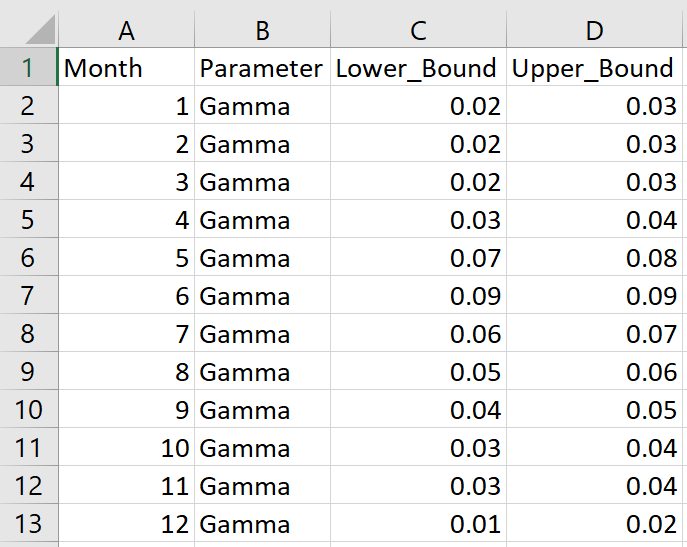
</div>

To fix particular parameter values we can use a table like:

<div>
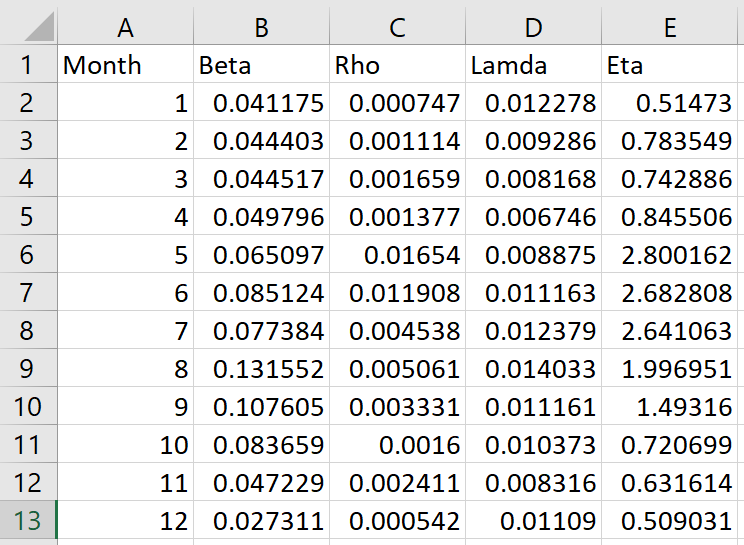
</div>

In the fit call itself we can specify these files as follows:

In [ ]:
rainfall_model.fit(
    n_workers=6,
    parameter_bounds='./input/fitting/parameter_bounds.csv',
    fixed_parameters='./input/fitting/fixed_parameters.csv',
    pdry_iterations=0,
    fit_shuffling=False,
    use_pooling=False,  # turn off use of "pooled statistics" for fitting in this example
)

The fit can be checked via the `plot` method, which can currently show annual cycles of statistics for one point/gauge at a time or spatial cross-correlations. For example, to plot annual cycles for one of the gauges specified in `point_metadata` we can use:

In [ ]:
rainfall_model.plot(point_id=3)

This time the plot shows both the reference statistics and the fitted statistics. This is the default behaviour, but we can use the `data_type` argument to specify what we want to plot if needed.

Note also that the skewness, dry probability and autocorrelation properties of the spatiotemporal NSRP process are the same everywhere in the domain. In contrast, these statistics can vary between locations in the reference (observed) data. The fitting process thus really tries to tend towards the "average" of all of the gauges for these statistics, although this is not yet reflected in the plots.

Cross-correlations can be visualised using:

In [ ]:
rainfall_model.plot(plot_type='cross-correlation')

## Simulation

If we just wanted to simulate stochastic time series for a set of gauge locations (i.e. those ones we specified earlier by setting `point_metadata` on initialisation), then we could call the `simulate` method in the same way that we did for the single site case:

```python
rainfall_model.simulate(
    simulation_length=200,  # use a relatively small number of years for online example
    n_realisations=1,
)
```

Note that the call above uses the default timestep of one hour.

If we want to produce additional catchment-average time series outputs there are a few extra options to specify. (Ultimately it will also be possible to write gridded output, but this option is not yet fully implemented.)

The code cell below indicates the extra options that can be specified:
 - `output_types` is a list (square brackets) indicating that we want both point (gauge) and catchment-average outputs
 - `catchment_metadata` points the model to the catchment shapefile discussed above
 - `epsg_code` refers to the EPSG code for the coordinate system of the catchment shapefile. This example in Germany uses the "WGS 84 / UTM zone 32N" coordinate system (https://epsg.io/32632). The code for the "British National Grid" would be 27700 (https://epsg.io/27700)
 - `cell_size` refers to the grid cell size (in metres) used to discretise the NSRP process when calculating catchment-average outputs (and ultimately gridded outputs if requested)
 - `dem` is specified as an ascii raster (which can be a different resolution to the `cell_size`)


In [ ]:
rainfall_model.simulate(
    output_types=['point', 'catchment'],
    catchment_metadata='./input/catchments.shp',
    epsg_code=32632,
    cell_size=1000.0,
    dem='./input/srtm_dem.asc',
    simulation_length=200,  # use a relatively small number of years for example
    n_realisations=1,
)

## Post-Processing

As in the single site example we can now do some post-processing to calculate/extract statistics of interest. The post-processing only runs for point (gauge) locations currently.

In [ ]:
rainfall_model.postprocess(
    amax_durations=[1, 3, 6, 24],
    ddf_return_periods=[2, 5],
)

We can then check that the simulated statistics are similar to the fitted ones:

In [ ]:
rainfall_model.plot(point_id=3)

In [ ]:
rainfall_model.plot(plot_type='cross-correlation')

This is the end of the main exercise.

## Additional Options: Loading a Model

This section demonstrates how to load a model based on files. See the single site example for more details, but essentially we can load reference statistics, fitted (model) statistics and parameter values by running the code cell below. This will replace the ``rainfall_model`` created/modified in any of the cells above.

In [ ]:
import rwgen  # only needed if this command has not been run previously (if it has that is fine)

# Initialise the model
rainfall_model = rwgen.RainfallModel(
    spatial_model=True,
    project_name='upper_rhine',
    input_timeseries='./input/gauge_data',
    intensity_distribution='weibull',
    point_metadata='./input/gauge_metadata.csv',
)

# Load reference and fitted (model) statistics from files
rainfall_model.set_statistics(
    reference_statistics='./_loading_example/reference_statistics.csv',
    fitted_statistics='./_loading_example/fitted_statistics.csv',
)

# Set parameter values from file
rainfall_model.set_parameters(
    parameters='./_loading_example/parameters.csv',
)

We could now proceed to do further simulations and post-processing by using the code cells in the Simulation and Post-Processing sections above.